# Simulate attack technique combinations
This file was used to test out some methods of simulation to get good ap results. The simulation itself was done in CreateSim.
## Create ground truth for malware
### Get data from DB

In [1]:
from neo4j import GraphDatabase
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
import random
import time
import numpy as np

In [7]:
driver = GraphDatabase.driver(uri = "bolt://localhost:7687", auth = ("neo4j", "team"))

mal_att = []
mal =[]
with driver.session() as session:
    result = session.run("MATCH (mal:Malware)--(att:Attack) RETURN mal, att")
    result2 = session.run("MATCH (mal:Malware) RETURN mal")
    for el in result:
        mal_att.append(el)
    for malware in result2:
        mal.append(malware["mal"]["name"])

### Create GT dict

In [11]:
mal_gt = {}
gt = [0] * 566

test = mal_att[0]["mal"]
test[0]

for malware in mal:
    for el in mal_att:
        if el["mal"]["name"] == malware:
            gt[el["att"].id] = 1
        else:
            pass
    mal_gt[malware] = gt
    gt = [0] * 566

## Different simulation techniques


### Functions

In [123]:
def calc_aps(simulations):
    start = time.time()
    aps = []
    for sim in simulations:
        aps.append(average_precision_score(mal_gt["3PARA RAT"], sim))
    t = time.time()-start
    print(f"Time needed to calculate the average precisions for one Malware based on {N} simulations: {t}s")
    a = max(aps)
    print(f"The maximum obtained average precision is: {a}")
    plt.hist(aps)
    plt.show()
    return aps

### Simple Bruteforce
In this approach the vectors of probabilities for techniques are created by generating random values for each techniques based on a uniform distribution.
In a second step the average precisions for a malware are calculated, based on all the simulated technique probability vectors.

In [15]:
N = 100000
start = time.time()
simulations = []
for i in range(N):
    simulation = []
    for x in range(566):
        simulation.append(random.randrange(0, 11, 1)/10)
    simulations.append(simulation)
t = time.time()-start
print(f"Time needed to create {N} technique probability vectors: {t}s")

Time needed to create 100000 technique probability vectors: 68.44042301177979s


Time needed to calculate the average precisions for one Malware based on 100000 simulations: 96.30929446220398s
The maximum obtained average precision is: 0.08935091277890467


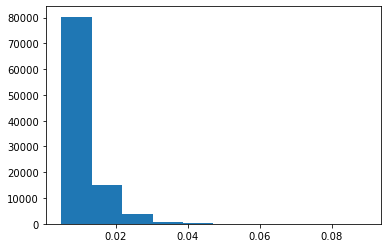

In [16]:
aps = calc_aps(simulations)

As can be seen in the histogram this approach is very inefficient and does not provide the needed output. The average precisions are very low to obtain enough simulations at all the desired levels of average precisions an unreasonable number of simulations would have to be created.

In [17]:
avg_n_t = 0
for mal in mal_gt.items():
    avg_n_t += sum(mal[1])
avg_n_t = avg_n_t/len(mal_gt)
print(f"Number of possible techniques: 566")
print(f"The average number of techniques used by a malware is: {avg_n_t}")
p = avg_n_t/566
print(f"average probability of technique being used (p): {p}")

Number of possible techniques: 566
The average number of techniques used by a malware is: 12.985200845665961
average probability of technique being used (p): 0.022942050964074135


The results are to be expected since out of 566 possible techniques on average only 13 are used by a malware. Therefore another way of simulating the results needs to be developed taking this imbalance into account.

### Bruteforce using Chisq distribution
Drawing the technique probability from a chisq distribution with one degree of freedom therefore giving a preference towards not using a technique.

In [126]:
N = 10000
start = time.time()
chi_simulations = []
for i in range(N):
    chi_simulations.append(np.clip(np.random.chisquare(1,566)/10, None, 1))
t = time.time()-start
print(f"Time needed to create {N} technique probability vectors: {t}s")

Time needed to create 10000 technique probability vectors: 1.291959524154663s


Time needed to calculate the average precisions for one Malware based on 10000 simulations: 8.009310483932495s
The maximum obtained average precision is: 0.5462774742726465


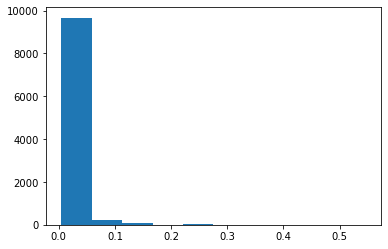

In [127]:
chi_aps = calc_aps(chi_simulations)

The results of this method are already a lot more promising the maximum average precision obtained is a lot higherthen when using a simple bruteforce methode. Still we can see from the histogram, that this method mostly creates simulations with a very low average precision. Therefore being very ineffective.
### Using a binomial distribution with probability p
In this approach the simulated technique vectors dont give a probability of a technique being used but instead a boolean value. With the probability of True (1) being the average probability a is being used over all malwares.

In [20]:
N = 100000
start = time.time()
bi_simulations = []
for i in range(N):
    bi_simulations.append(np.random.binomial(1, p, 566))
t = time.time()-start
print(f"Time needed to create {N} technique probability vectors: {t}s")

Time needed to create 100000 technique probability vectors: 1.7409443855285645s


Time needed to calculate the average precisions for one Malware based on 100000 simulations: 81.89340829849243s
The maximum obtained average precision is: 0.28301678445229683


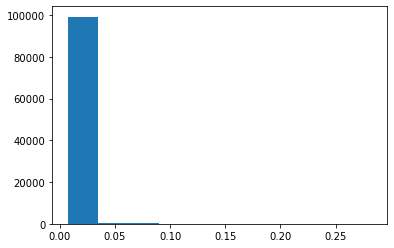

In [21]:
bi_aps = calc_aps(bi_simulations)

### Using a binomial distribution with probability of only one malware
The probabity of a technique being used is now the proportion of used techniques by one malware to its unuesd techniques.

In [23]:
p_rat = sum(mal_gt["3PARA RAT"])/566
print(p_rat)
N = 100000
start = time.time()
bi2_simulations = []
for i in range(N):
    bi2_simulations.append(np.random.binomial(1, p_rat, 566))
t = time.time()-start
print(f"Time needed to create {N} technique probability vectors: {t}s")

0.007067137809187279
Time needed to create 100000 technique probability vectors: 1.3109502792358398s


Time needed to calculate the average precisions for one Malware based on 100000 simulations: 75.63863348960876s
The maximum obtained average precision is: 0.336866902237927


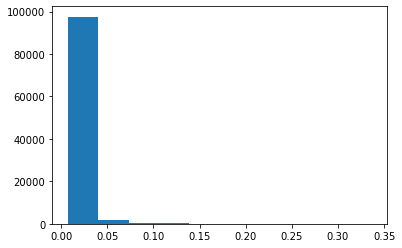

In [24]:
bi2_aps = calc_aps(bi2_simulations)

Using either of the probabilites does not yield very promising results. In order to get more accurate and efficient results the gt needs to be taken more into account
### Using different probabilites based on gt
Example if the technique in the gt is used the probability of it being in the simulation is higher then if not.

In [111]:
mal_t = mal_gt["3PARA RAT"]
g = [i for i, e in enumerate(mal_t) if e == 1]

In [26]:
for sim in bi_simulations:
    for ind in g:
        sim[ind] = np.random.binomial(1, 0.9, 1)

Time needed to calculate the average precisions for one Malware based on 100000 simulations: 87.58623957633972s
The maximum obtained average precision is: 0.8


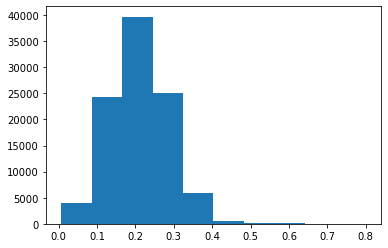

In [27]:
bi_aps = calc_aps(bi_simulations)

Results look a lot better, but a lot of aps are not among the values. Try the same thing with the chi_sq with multiple different dfs.

<class 'int'>
Time needed to calculate the average precisions for one Malware based on 10000 simulations: 7.924750804901123s
The maximum obtained average precision is: 1.0


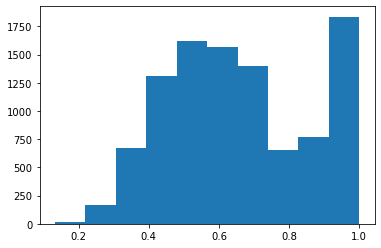

<class 'int'>
Time needed to calculate the average precisions for one Malware based on 10000 simulations: 8.193742275238037s
The maximum obtained average precision is: 1.0


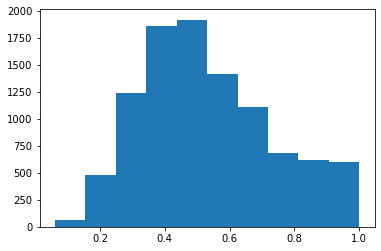

<class 'int'>
Time needed to calculate the average precisions for one Malware based on 10000 simulations: 7.741765975952148s
The maximum obtained average precision is: 1.0


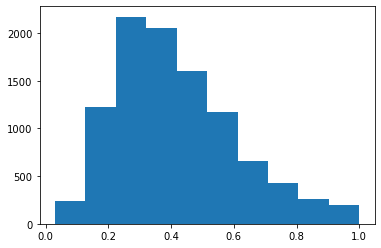

<class 'int'>
Time needed to calculate the average precisions for one Malware based on 10000 simulations: 7.933759450912476s
The maximum obtained average precision is: 1.0


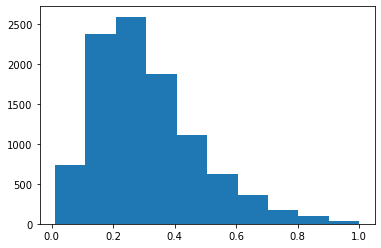

<class 'int'>
Time needed to calculate the average precisions for one Malware based on 10000 simulations: 8.064746618270874s
The maximum obtained average precision is: 1.0


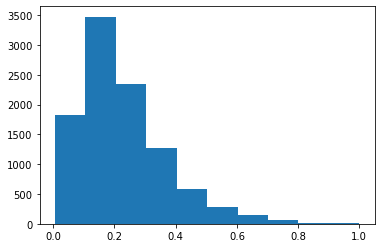

In [124]:
N = 10000
aps_df = []
for df in range(1, 6):
    print(type(b))
    chi_simulations = []
    for i in range(N):
        chi_simulations.append(np.clip(np.random.chisquare(1,566)/10, None, 1))
    for sim in chi_simulations:
        for ind in g:
            sim[ind] = 1 - np.clip(np.random.chisquare(df, 1)/10, None, 1)
    aps_df.append(calc_aps(chi_simulations))

In [125]:
for aps in aps_df:
    rnd = [round(x, 1) for x in aps]
    counts = []
    for i in range(0, 11):
        i = i/10
        counts.append(rnd.count(i))
    print(counts)

[0, 1, 42, 386, 1305, 1860, 1737, 1455, 788, 826, 1600]
[0, 51, 498, 1342, 2003, 1921, 1485, 969, 754, 484, 493]
[13, 429, 1532, 2260, 2045, 1482, 986, 509, 425, 162, 157]
[76, 1511, 2687, 2338, 1520, 910, 493, 242, 146, 50, 27]
[374, 3079, 3085, 1778, 909, 413, 200, 103, 46, 8, 5]


In [104]:
counts = []
for i in range(0, 11):
    i = i/10
    counts.append(test.count(i))
counts

[1, 39, 452, 1336, 2081, 1910, 1557, 909, 752, 451, 512]

## Multiprocessing
Multiprocessing improves the performance. It does however not run in notebook.

Current status: have a look at how the chisq method performs on other malwares. Implement in CreateSim with multipr.